In [1]:
%%time
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# 데이터 로딩 및 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

CPU times: user 3.02 s, sys: 1.49 s, total: 4.51 s
Wall time: 10.9 s


In [2]:
%%time
# BasicBlock 정의
def BasicBlock(inputs, filters, stride=1):
    shortcut = inputs

    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# ResNet 정의
def ResNet18():
    inputs = Input(shape=(32, 32, 3))

    x = Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = BasicBlock(x, 64)
    x = BasicBlock(x, 64)
    x = BasicBlock(x, 128, stride=2)
    x = BasicBlock(x, 128)
    x = BasicBlock(x, 256, stride=2)
    x = BasicBlock(x, 256)
    x = BasicBlock(x, 512, stride=2)
    x = BasicBlock(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [3]:
%%time
model = ResNet18()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [4]:
%%time
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

CPU times: user 8.87 ms, sys: 1.45 ms, total: 10.3 ms
Wall time: 8.55 ms


In [5]:
%%time
# 학습 루프 batch_size = 64 로 오리지널에 비해 2배 증가, 에폭 30회만 진행
history = model.fit(x_train, y_train, batch_size=64, epochs=30)
test_loss, test_acc = model.evaluate(x_test, y_test)

# 모델 평가
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Epoch 1/30
782/782 [==============================] - 54s 62ms/step - loss: 1.2785 - accuracy: 0.5448
Epoch 2/30
782/782 [==============================] - 50s 64ms/step - loss: 0.7646 - accuracy: 0.7319
Epoch 3/30
782/782 [==============================] - 49s 63ms/step - loss: 0.5708 - accuracy: 0.8007
Epoch 4/30
782/782 [==============================] - 50s 63ms/step - loss: 0.4429 - accuracy: 0.8458
Epoch 5/30
782/782 [==============================] - 49s 63ms/step - loss: 0.3498 - accuracy: 0.8782
Epoch 6/30
782/782 [==============================] - 50s 63ms/step - loss: 0.2629 - accuracy: 0.9067
Epoch 7/30
782/782 [==============================] - 50s 63ms/step - loss: 0.1932 - accuracy: 0.9312
Epoch 8/30
782/782 [==============================] - 50s 63ms/step - loss: 0.1411 - accuracy: 0.9507
Epoch 9/30
782/782 [==============================] - 50s 64ms/step - loss: 0.1115 - accuracy: 0.9608
Epoch 10/30
782/782 [==============================] - 50s 63ms/step - loss: 0.087

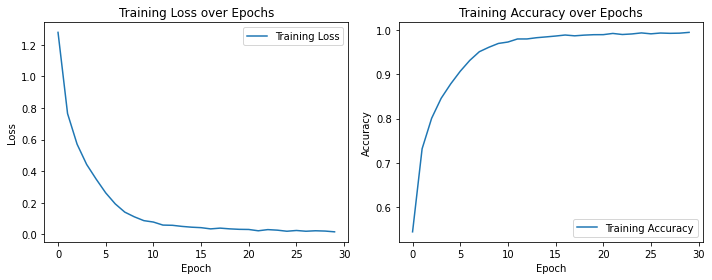

CPU times: user 569 ms, sys: 274 ms, total: 843 ms
Wall time: 405 ms


In [6]:
%%time
# 학습 결과 시각화
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# batch_size = 64로 증가 & 에폭 30회 실행
# 에폭 30회 연산 시간 : 24 : 58
# Train acc : 0.99
# Test acc : 0.83
# Test loss : 0.9555

# Test01과 비교 (Test01 에폭 100회 연산 시간 : 1: 24 : 19)
# 에폭 30회 연산을 초로 환산 : (24* 60) + 58 = 1,498
# 환산된 값에 10/3을 곱셈 : 1,498 / 3 * 10 = 4,993
# 4,993 / 60 = 83.22 = 약 1시간 23 분 13초

# 약 1분 정도의 차이만 나는 점을 보여 파이프라인 작업이 큰 유의미성을 못뛰우는 점으로 확인됨
# Test05에서도 batch_size만 늘렸을때와 비슷한지 비교 실행 예정